In [5]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [26]:
import torch
import torch.nn as nn

class ShiftedLegendrePolynomialBatch(nn.Module):
    """
    A PyTorch module that represents a batch of shifted Legendre polynomials
    up to a specified maximum order on [0,1], along with their derivatives.

    For each order n, the shifted Legendre polynomial is defined as:
        P_n^shifted(x) = P_n(2x - 1),
    where P_n is the standard Legendre polynomial on [-1,1].

    Given an input tensor x, the module evaluates all P_n^shifted(x) and their
    derivatives dP_n^shifted(x)/dx for n from 1 to max_order and returns them
    as tensors.
    """
    def __init__(self, max_order):
        """
        Args:
            max_order (int): The maximum order of Legendre polynomials to compute (>=1).
        """
        super().__init__()
        if not isinstance(max_order, int) or max_order < 1:
            raise ValueError("max_order must be an integer >= 1.")
        self.max_order = max_order

    def forward(self, x):
        """
        Evaluate shifted Legendre polynomials up to max_order at points x in [0,1].

        Args:
            x (torch.Tensor): Input tensor of shape (N,) or (N,1) with values in [0,1].

        Returns:
            torch.Tensor: Tensor of shape (N, max_order) containing the evaluations
                          of P_1^shifted(x) to P_max_order^shifted(x) for each input x.
        """
        # Ensure x is a 1D tensor
        if x.dim() == 2 and x.size(1) == 1:
            x = x.squeeze(1)
        elif x.dim() != 1:
            raise ValueError("Input tensor x must be of shape (N,) or (N,1).")

        # Shift x from [0,1] to z in [-1,1]
        z = 2.0 * x - 1.0  # Shape: (N,)

        # Compute all polynomials P0 to P_max_order
        P = self._compute_polynomials(z)  # Shape: (N, max_order +1)

        # Extract P1 to P_max_order
        P_shifted = P[:, 1:]  # Shape: (N, max_order)

        return P_shifted

    def derivative(self, x):
        """
        Compute the derivatives of shifted Legendre polynomials up to max_order
        at points x in [0,1].

        d/dx [P_n^shifted(x)] = 2 * P_n'(z),
        where z = 2x - 1 and P_n'(z) is the derivative of the standard Legendre
        polynomial.

        Args:
            x (torch.Tensor): Input tensor of shape (N,) or (N,1) with values in [0,1].

        Returns:
            torch.Tensor: Tensor of shape (N, max_order) containing the derivatives
                          dP_1^shifted(x)/dx to dP_max_order^shifted(x)/dx for each input x.
        """
        # Ensure x is a 1D tensor
        if x.dim() == 2 and x.size(1) == 1:
            x = x.squeeze(1)
        elif x.dim() != 1:
            raise ValueError("Input tensor x must be of shape (N,) or (N,1).")

        # Shift x from [0,1] to z in [-1,1]
        z = 2.0 * x - 1.0  # Shape: (N,)

        # Compute all polynomials P0 to P_max_order
        P = self._compute_polynomials(z)  # Shape: (N, max_order +1)

        # Prepare n = 1 to max_order
        device = z.device
        n = torch.arange(1, self.max_order + 1, device=device).float()  # Shape: (max_order,)

        # Compute denominator (1 - z^2), shape: (N,)
        denominator = 1.0 - z ** 2 + 1e-9  # Shape: (N,)

        # To prevent division by zero, you might want to add a small epsilon
        # For now, we'll proceed as per the formula, which may produce inf or nan.

        # Compute (z * P_n - P_{n-1}) for each n, shape: (N, max_order)
        numer = z.unsqueeze(1) * P[:, 1:] - P[:, :-1]  # Shape: (N, max_order)

        # Compute derivative P_n'(z) = n / (1 - z^2) * (z * P_n(z) - P_{n-1}(z))
        # Shape: (N, max_order)
        dPdz = (n / denominator.unsqueeze(1)) * numer  # Shape: (N, max_order)

        # Chain rule: dP_n^shifted/dx = 2 * P_n'(z)
        dPdx = 2.0 * dPdz  # Shape: (N, max_order)

        return - dPdx

    def _compute_polynomials(self, z):
        """
        Compute standard Legendre polynomials P0 to P_max_order at points z.

        Uses the recursive relation:
            P0(z) = 1
            P1(z) = z
            (k+1)P_{k+1}(z) = (2k + 1)z P_k(z) - k P_{k-1}(z)

        Args:
            z (torch.Tensor): Tensor of shape (N,) with values in [-1,1].

        Returns:
            torch.Tensor: Tensor of shape (N, max_order +1) containing P0 to P_max_order.
        """
        N = z.shape[0]
        device = z.device

        # Initialize list with P0 and P1
        P_list = [torch.ones_like(z), z.clone()]  # P0, P1

        # Compute P2 to P_max_order using recursion
        for k in range(1, self.max_order):
            # Recurrence relation:
            # (k +1)P_{k+1}(z) = (2k +1)z P_k(z) - k P_{k-1}(z)
            P_k = P_list[-1]  # P_k(z)
            P_km1 = P_list[-2]  # P_{k-1}(z)
            P_kp1 = ((2.0 * k + 1.0) * z * P_k - k * P_km1) / (k + 1.0)
            P_list.append(P_kp1)

        # Stack into tensor of shape (N, max_order +1)
        P = torch.stack(P_list, dim=1)  # Shape: (N, max_order +1)

        return P

# # Example usage:
# if __name__ == "__main__":
#     # Define maximum order
#     max_order = 5

#     # Initialize the module
#     legendre_batch = ShiftedLegendrePolynomialBatch(max_order=max_order)

#     # Create input tensor x in [0,1]
#     x = torch.linspace(0, 1, steps=10)  # Shape: (10,)

#     # Evaluate polynomials
#     polynomials = legendre_batch(x)  # Shape: (10, 5)

#     # Evaluate derivatives
#     derivatives = legendre_batch.derivative(x)  # Shape: (10, 5)

#     # Display results
#     print("Input x:")
#     print(x)
#     print("\nShifted Legendre polynomials up to order {}:".format(max_order))
#     print(polynomials)
#     print("\nDerivatives of shifted Legendre polynomials up to order {}:".format(max_order))
#     print(derivatives)


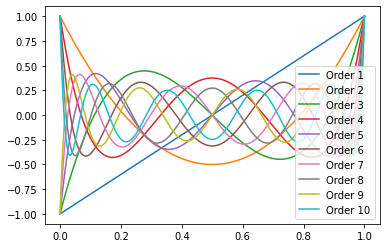

In [18]:
legendre_batch = ShiftedLegendrePolynomialBatch(max_order=10)
x_vals = torch.linspace(0,1,1000)
polynomials = legendre_batch(x_vals).detach().numpy()
for i in range(polynomials.shape[1]):
    plt.plot(x_vals, polynomials[:,i], label=f"Order {i+1}")
plt.legend()

In [29]:
def compare_derivatives(max_order):
    import matplotlib.pyplot as plt

    # Define maximum order
    # max_order = 5

    # Initialize the module
    legendre_batch = ShiftedLegendrePolynomialBatch(max_order=max_order)

    # Create input tensor x in [0,1] with requires_grad=True
    x = torch.linspace(0.001, 0.999, steps=1000, requires_grad=True)  # Shape: (100,)

    # Evaluate polynomials using the module
    P = legendre_batch(x)  # Shape: (100, 5)

    # Initialize a tensor to hold autograd derivatives
    autograd_derivatives = torch.zeros_like(P)

    # Compute derivatives via autograd
    for n in range(max_order):
        # Zero existing gradients
        if x.grad is not None:
            x.grad.zero_()
        
        # Select P_n(x), where n ranges from 0 to max_order-1
        Pn = P[:, n]  # Shape: (100,)

        # Compute gradients: dP_n/dx for each x
        # To compute element-wise gradients, set grad_outputs to ones
        grad_outputs = torch.ones_like(Pn)
        grads = torch.autograd.grad(
            outputs=Pn,
            inputs=x,
            grad_outputs=grad_outputs,
            retain_graph=True,
            create_graph=False
        )[0]  # Shape: (100,)

        # Store the gradients
        autograd_derivatives[:, n] = grads

    # Compute derivatives using the module's derivative method
    module_derivatives = legendre_batch.derivative(x)  # Shape: (100, 5)

    # Compare the derivatives
    difference = torch.abs(autograd_derivatives - module_derivatives)
    max_diff = difference.max().item()
    mean_diff = difference.mean().item()

    print(f"Maximum difference between autograd and module's derivatives: {max_diff:.6e}")
    print(f"Mean difference between autograd and module's derivatives: {mean_diff:.6e}")

    # Optionally, assert that the differences are within a tolerance
    tolerance = 1e-6
    if torch.all(difference < tolerance):
        print(f"\nAll derivative differences are below the tolerance of {tolerance}.")
    else:
        print(f"\nSome derivative differences exceed the tolerance of {tolerance}.")

    # Print a few sample differences
    print("\nSample differences (autograd - module):")
    for n in range(max_order):
        max_diff_n = difference[:, n].max().item()
        mean_diff_n = difference[:, n].mean().item()
        print(f"Order {n+1}: Max diff = {max_diff_n:.6e}, Mean diff = {mean_diff_n:.6e}")

    # Plot the derivatives for visual comparison
    for n in range(max_order):
        plt.figure(figsize=(8, 4))
        plt.plot(x.detach().numpy(), autograd_derivatives[:, n].detach().numpy(),
                 label='Autograd derivative', color='blue')
        plt.plot(x.detach().numpy(), module_derivatives[:, n].detach().numpy(),
                 '--', label='Module derivative', color='red')
        plt.title(f'Derivative Comparison for Order {n+1}')
        plt.xlabel('x')
        plt.ylabel(f'dP_{n+1}/dx')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Maximum difference between autograd and module's derivatives: 3.871918e-04
Mean difference between autograd and module's derivatives: 1.086626e-06

Some derivative differences exceed the tolerance of 1e-06.

Sample differences (autograd - module):
Order 1: Max diff = 4.768372e-07, Mean diff = 2.300739e-08
Order 2: Max diff = 3.576279e-05, Mean diff = 5.276771e-07
Order 3: Max diff = 6.294250e-05, Mean diff = 1.035479e-06
Order 4: Max diff = 1.602173e-04, Mean diff = 1.331954e-06
Order 5: Max diff = 3.871918e-04, Mean diff = 2.515010e-06


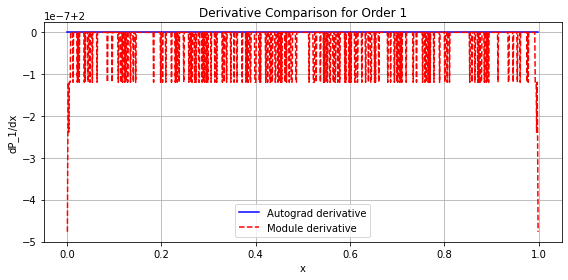

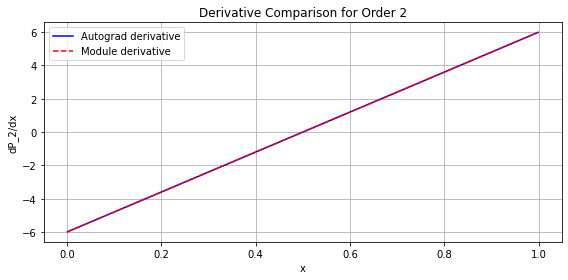

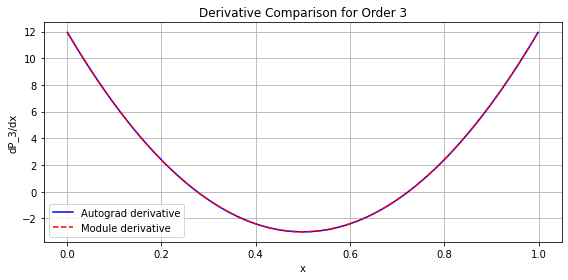

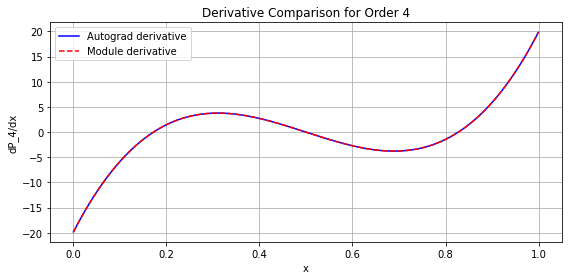

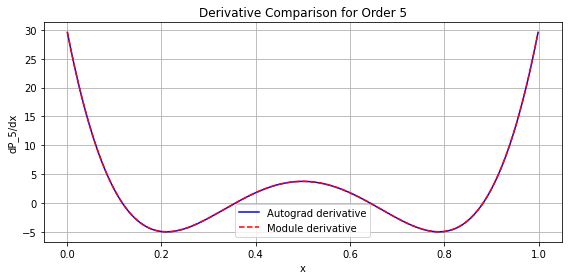

In [30]:
compare_derivatives(5)